# Hypothesis Testing of the Difference Between Two Population Means
Carlo Maria Olmi - Data Scientist 

### Table of content:
* Introduction to Frequetist AB Testing
* Comparing two proportion
* Introducing Power
* Determining Sample Size
* Chi-Square test

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt


In [4]:
# setup the look and feel of the notebook
plt.rcParams['figure.figsize'] = 13, 15
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth': 2.5})
sns.set_style('whitegrid')
sns.set_palette('deep')

# Create a couple of colors to use throughout the notebook
red = sns.xkcd_rgb['vermillion']
blue = sns.xkcd_rgb['dark sky blue']

In [30]:
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')

# Frequentist A/B testing

A/B testing is essentially a simple randomized trial. Randomized trials are (usually) considered the gold standard study design for evaluating the efficacy of new medical treatments, but they are also used much more widely in experimental research.

In marketing and web analytics, A/B testing (bucket tests or split-run testing) is a controlled experiment with two variants, A and B. It is a form of statistical hypothesis testing or "two-sample hypothesis testing" as used in the field of statistics. In online settings, such as web design (especially user experience design), the goal of A/B testing is to identify changes to web pages that increase or maximize an outcome of interest (e.g., click-through rate for a banner advertisement). Formally the current web page is associated with the null hypothesis. A/B testing is a way to compare two versions of a single variable typically by testing a subject's response to variable A against variable B, and determining which of the two variables is more effective.

As the name implies, two versions (A and B) are compared, which are identical except for one variation that might affect a user's behavior. Version A might be the currently used version (control), while version B is modified in some respect (treatment). For instance, on an e-commerce website the purchase funnel is typically a good candidate for A/B testing, as even marginal improvements in drop-off rates can represent a significant gain in sales. 

Multivariate testing or multinomial testing is similar to A/B testing, but may test more than two versions at the same time or use more controls. 


The key idea is that because we randomize which landing page someone goes to, after a large number of visitors, the groups of people who visited the two pages are completely comparable in respect of all characteristics (e.g. age, gender, location, and anything else you can think of!). Because the two groups are comparable, we can compare the outcomes (e.g. amount of advertising revenue) between the two groups to obtain an unbiased, and fair, assessment of the relative effectiveness (in terms of our defined outcome) of the two designs.


Scenario: We ran an A/B test with two different versions of a web page, A and B, for which we count the number of visitors and whether they convert or not. We can summarize this in a contingency table showing the frequency distribution of the events:

In [31]:
data = pd.DataFrame({
    'version': ['A', 'B'],
    'not_converted': [4514, 4473],
    'converted': [486, 527]
})[['version', 'not_converted', 'converted']]
data

,version,not_converted,converted
0,A,4514,486
1,B,4473,527


In [32]:
for index, row in data.iterrows():
    print float(row['converted'])/float((row['converted']+row['not_converted']))


0.0972
0.1054


It is trivial to compute the conversion rate of each version, 486/(486 + 4514) = 9.72% for A and 10.5% for B. With such a relatively small difference, however, can we convincingly say that the version b converts better? To test the statistical significance of a result like this, a hypothesis testing can be used.

## Comparing Two Proportions

Let's formalize our thought process a little bit, suppose that we have obtained data from n visitors, $n_A$ of which have been (randomly) sent to page A, and $n_B$ of which have been sent to page B. Further, let $X_A$ and $X_B$ denote the number of visitors for whom we obtained a 'successful' outcome in the two groups. The proportion of successes in the two groups is then given by $\hat{p_A} = X_A/n_A$ and $\hat{p_B} = X_B/n_B$ respectively. The estimated difference in success rates is then give by the difference in proportions: $\hat{p_A} - \hat{p_B}$:

To assess whether we have statistical evidence that the two pages' success rates truely differ, we can perform a hypothesis test. The null hypothesis that we want to test is that the two pages' true success rates are equal, whereas the alternative is that they differ (one is higher than the other). If $p_A$ = the proportion of the page A population whom we obtained a successful outcome and $p_B$ = the proportion of the page B population whom we obtained a successful outcome then we are interested in testing the following hypothesis:

\begin{align}
H_0:p_A = p_B \text{ versus } H_A: p_A \neq p_B
\end{align}

Or put it in another way, the null hypothesis says that the factors 'page type' and 'outcome' are statistically independent of each other. In words, this means knowing which page someone is sent to tells you nothing about the chance that they will have a successful outcome. Now that we know what hypothesis test we're interested in, we'll have to derive the appropriate test statistic.

A test statistic is a single metric that can be used to evaluate the null hypothesis and the standard way to obtain this metric is to compute the z-score that measures how many standard deviations below or above the population mean a raw score is: 

\begin{align}
z = \frac{x - \mu}{SE}
\end{align}

Where:

- $\mu$ denotes the mean
- $SE$ or sometimes seen as the symbol $\sigma$ denotes the standard error, computed by $\frac{s}{\sqrt{n}}$, where $s$ denotes the standard error and $n$ denotes the number of samples

The following link contains an example of where this is applied in proportion hypothesis testing for those who feels uncomfortable with this concept.

For our test the underlying metric is a binary yes/no variable (event), which means the appropriate test statistic is a test for differences in proportions:

\begin{align}
Z = \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)}
\end{align}

The test statistic makes sense as it measuring the difference in the observed proportions and the estimated proportion, standardized by an estimate of the standard error of this quantity.

To compute the test statistic, we first need to find the standard deviation/variance of $p_A - p_B$:

\begin{align}
Var(p_A - p_B)
&= Var(p_A) +  Var(p_B) \\
&= \frac{p_A (1 - p_A)}{n_A} + \frac{p_B (1 - p_B)}{n_B} \\
&= p (1 - p) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)
\end{align}

- The first step stems from that fact that, given that we know:
    - The variance of a random variable X is defined as $Var(X) = E[X^2] - E[X]^2$
    - The covariance between two random variable X and Y is defined as $Cov(X, Y) = E[(X - u_x)(y - u_y)] = E[XY] - E[X]E[Y]$
    - When conducting hypothesis test, we know that the two groups should be independent of each other, i.e. the covariance between the two should be 0

\begin{align}
Var(X - Y)
&= E[(X - Y)(X - Y)] - E[X - Y]^2 \\
&= E[X^2 - 2XY + Y^2] - (u_x - u_y)^2 \\
&= E[X^2 - 2XY + Y^2] - u_x^2 + 2u_xu_y - u_y^2 \\
&= (E[X^2] - u_x^2) + (E[Y^2] - u_y^2) - 2(E[XY] - u_xu_y) \\
&= Var(X) + Var(Y) - 2 Cov(X, Y)
\end{align}

- We're using the property that the variance of a binomial proportion is given by: $Var(p_A) = p_A (1 - p_A) / n_A$, the same can be applied for group B
- The third step comes from the fact that if we assume that the null hypothesis, $p_A = p_B$ is true, then the population proportions equal some common value $p$, that is, $p_A = p_B = p$. Since we don't know the assumed common population proportion $p$ any more than we know the proportions $p_A$ and $p_B$ of each population, we can estimate $p$ using the proportion of "successes" in the two combined, $\hat{p} = (X_A + X_B)/(n_A + n_B)$, which is commonly referred to as the **pooled probability**

During the third step, we utilized that fact that if we assume that the null hypothesis is true, then $p_A = p_B$, this also means $p_A - p_B = 0$. Given all of these information, the formula for our test statistic now becomes:

\begin{align}
Z
&= \frac{ (\hat{p_A} - \hat{p_B}) - (p_A - p_B) }{SE(p_A - p_B)} \\
&= \frac{ (\hat{p_A} - \hat{p_B}) - 0 }{\sqrt{\hat{p} (1 - \hat{p}) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)}}
\end{align}

Where $\hat{p} = (X_A + X_B)/(n_A + n_B)$

In [33]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [34]:
success_a = 486.0
size_a = 5000.0
success_b = 527.0
size_b = 5000.0

zscore, pvalue = two_proprotions_test(success_a, size_a, success_b, size_b)
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = 1.359, pvalue = 0.174


In [35]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

In [36]:
# or we can use the implementation from statsmodels
# where we pass in the success (they call the argument counts)
# and the total number for each group (they call the argument nobs,
# number of observations)
counts = np.array([486, 527])
nobs = np.array([5000, 5000])

zscore, pvalue = proportions_ztest(counts, nobs, alternative = 'two-sided')
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = -1.359, pvalue = 0.174


Based on the fact that our p-value is not smaller than the 0.05 commonly used threshold, the test statistic tells us we do not have strong evidence against our null hypothesis, i.e. we do not have strong evidence that the two pages are not equally effective.

Apart from spitting out the p-value, we will also look at forming a confidence interval for $\hat{p_A} - \hat{p_B}$. If the number of trials in both groups is large, and the observed number of successes are not too small, we can calculate a 95% confidence interval using the formula:

\begin{align}
\text{point estimate} \pm z * SE
&= (\hat{p_A} - \hat{p_B}) \pm z * \frac{p_A (1 - p_A)}{n_A} + \frac{p_B (1 - p_B)}{n_B}
\end{align}

Note that when calculating the confidence interval because we no longer have the assumption that $p_A = p_B$ from our null hypothesis, thus we can't leverage this property and use the pooled probability.

| Scenario       | $H_0$ is true                      | $H_0$ is false            |
|:--------------:|:----------------------------------:|:-------------------------:|
|  Accept $H_0$  |  Correct Decision                  |  Type 2 Error (1 - power) |
|  Reject $H_0$  |  Type 1 Error (significance level) |  Correct decision         |


To determine whether the difference between the population proportions is statistically significant, compare the p-value to the significance level. Usually, a significance level (denoted as α or alpha) of 0.05 works well. A significance level of 0.05 indicates a 5% risk of concluding that a difference exists when there is no actual difference.

* P-value $≤ α$: The difference between the proportions is statistically significant (Reject H0)
If the p-value is less than or equal to the significance level, the decision is to reject the null hypothesis. You can conclude that the difference between the population proportions is statistically significant. Use your specialized knowledge to determine whether the difference is practically significant.
* P-value $> α$: The difference between the proportions is not statistically significant (Fail to reject H0)
If the p-value is greater than the significance level, the decision is to fail to reject the null hypothesis. You do not have enough evidence to conclude that the difference between the population means is statistically significant.

In [37]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its confidence interval;
    resulting confidence interval matches R's prop.test function
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
        
    Returns
    -------
    prop_diff : float
        Difference between the two proportion
    
    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    
    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [38]:
prop_diff, confint = two_proprotions_confint(success_a, size_a, success_b, size_b)
print('estimate difference:', prop_diff)
print('confidence interval:', confint)

('estimate difference:', 0.008199999999999999)
('confidence interval:', array([-0.00362633,  0.02002633]))


Up till this point, we've been using the 5000 as the total number of observations/samples that are involved in the A/B testing process. The next question that we'll address is, in real world scenarios, how many obeservations do we need in order to draw a valid verdict on the test result. This leads us to our next topic **power**.


## Introducing Power

In the world of hypothesis testing, rejecting the null hypothesis when it is actually true is called a type 1 error, often denoted as $\alpha$. Committing a type 1 error is a false positive because we end up recommending something that does not work. Conversely, a type 2 error, often denoted as $\beta$, occurs when you do not reject the null hypothesis when it is actually false. This is a false negative because we end up sitting on our hands when we should have taken action. We need to consider both of these types of errors when choosing the sample size.

Two important probabilities related to type 1 and type 2 error are:

- **Significance level:** Governs the chance of a false positive. A significance level of 0.05 means that there is a 5% chance of a false positive. Choosing level of significance is an arbitrary task, but for many applications, a level of 5% is chosen, for no better reason than that it is conventional
- **Statistical power** Power of 0.80 means that there is an 80% chance that if there was an effect, we would detect it (or a 20% chance that we'd miss the effect). In other words, power is equivalent to $1 - \beta$. There are no formal standards for power, most researchers assess the power of their tests using 0.80 for adequacy

| Scenario       | $H_0$ is true                      | $H_0$ is false            |
|:--------------:|:----------------------------------:|:-------------------------:|
|  Accept $H_0$  |  Correct Decision                  |  Type 2 Error (1 - power) |
|  Reject $H_0$  |  Type 1 Error (significance level) |  Correct decision         |

The concepts of power and significance level can seem somewhat convoluted at first glance. A good way to get a feel for the underlying mechanics is to plot the probability distribution of $Z$ assuming that the null hypothesis is true. Then do the same assuming that the alternative hypothesis is true, and overlay the two plots.

Consider the following example: $H_0: p_A = p_B, H_1: p_A > p_B$. A one-sided test was chosen here for charting-simplicity.

- Total sample size, N=5,000 (assume equal sample sizes for the control and experiment groups, meaning exactly 2,500 in each group)
- Say we decide that we need to observe a difference of 0.02 (detailed later) in order to be satisfied that the intervention worked (i.e., assuming that our original baseline, $p_B$ was 0.08, then we want $p_A = 0.10$). We will discuss how to make this decision later in the post

In [39]:
def plot_power(min_diff, prob_b, size_a, size_b, significance = 0.05):
    """illustrating power through a one-tailed hypothesis test"""
    
    # obtain the z-score for the minimum detectable
    # difference using proportion_ztest
    prob_a = prob_b + min_diff
    count_a = size_a * prob_a
    count_b = size_b * prob_b
    counts = np.array([count_a, count_b])
    nobs = np.array([size_a, size_b])
    zscore, _ = proportions_ztest(counts, nobs, alternative = 'larger')

    # distribution for the null hypothesis, h0
    # and alternative hypothesis, h1
    h0 = stats.norm(loc = 0, scale = 1)
    h1 = stats.norm(loc = zscore, scale = 1)

    # points that are greater than the zscore for the
    # specified significance level
    x = np.linspace(-5, 6, num = 100)
    threshold = h0.ppf(1 - significance)
    mask = x > threshold
    
    # power is the area after the threshold, i.e.
    # 1 - the cumulative distribution function of that point
    power = np.round(1 - h1.cdf(threshold), 2)

    hypotheses = [h1, h0]
    labels = ['$H_1$ is true', '$H_0$ is true']
    for hypothesis, label in zip(hypotheses, labels):
        y = hypothesis.pdf(x)
        line = plt.plot(x, y, label = label)  
        plt.fill_between(x = x[mask], y1 = 0.0, y2 = y[mask],
                         alpha = 0.2, color = line[0].get_color())
        
    title = 'p1: {}, p2: {}, size1: {}, size2: {}, power: {}'
    plt.title(title.format(prob_a, prob_b, size_a, size_b, power))
    plt.legend()
    plt.tight_layout()
    plt.show()

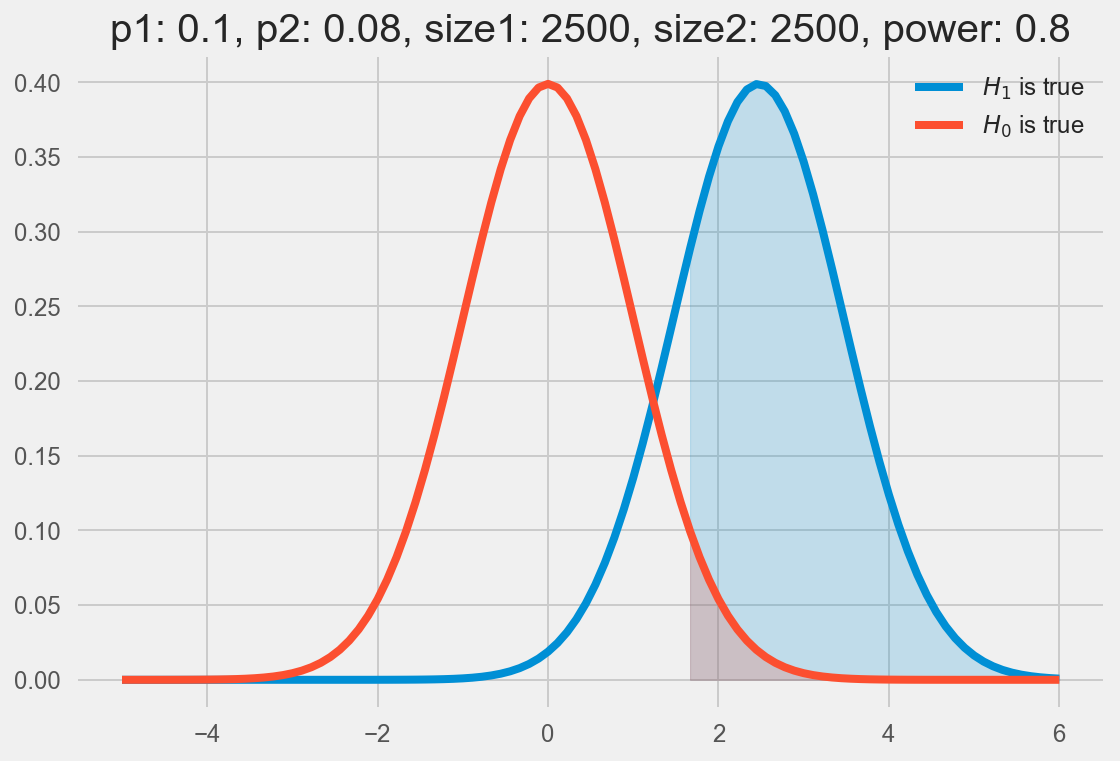

In [40]:
prob_b = 0.08
min_diff = 0.02
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)

The shaded orange area denotes the significance region, while the the shaded blue area denotes the power (note that it includes the shaded orange area). Note that if we pick a smaller N, or a smaller probability difference between the control and experiment group, the power drops (the shaded blue area decreases), meaning that if there’s is in fact a change, there’s lesser percent chance that we’ll detect it.

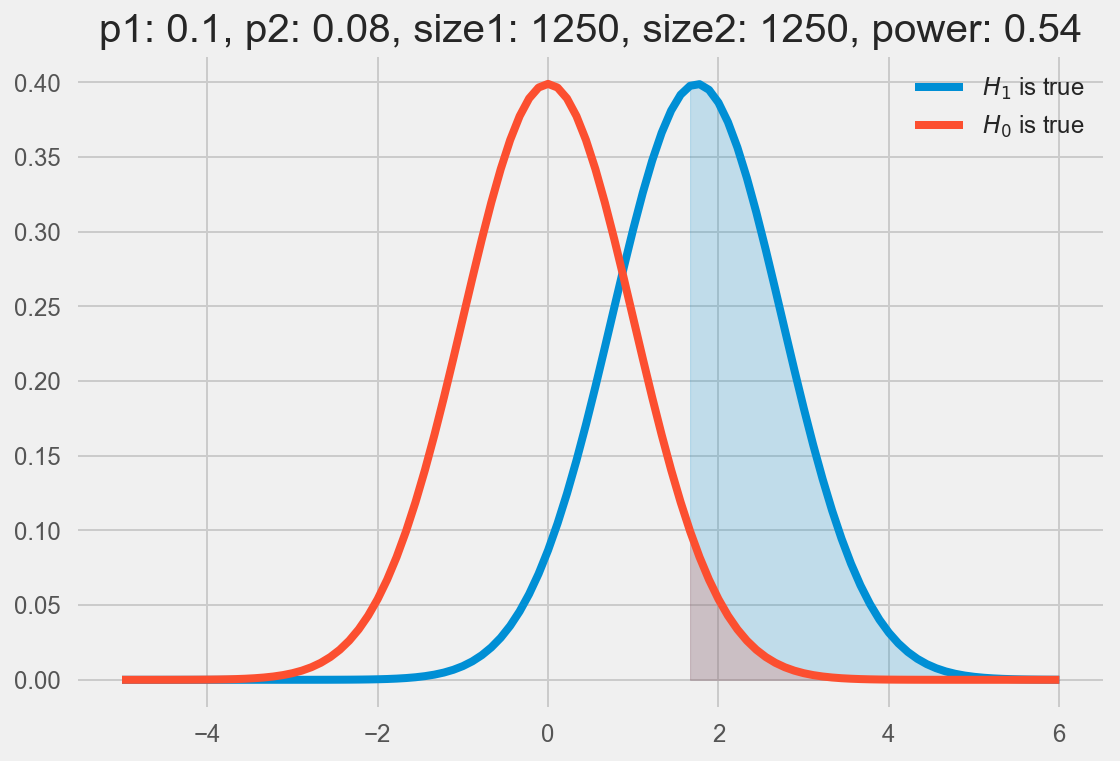

In [41]:
# smaller N
prob_b = 0.08
min_diff = 0.02
size_a = 1250
size_b = 1250

plot_power(min_diff, prob_b, size_a, size_b)

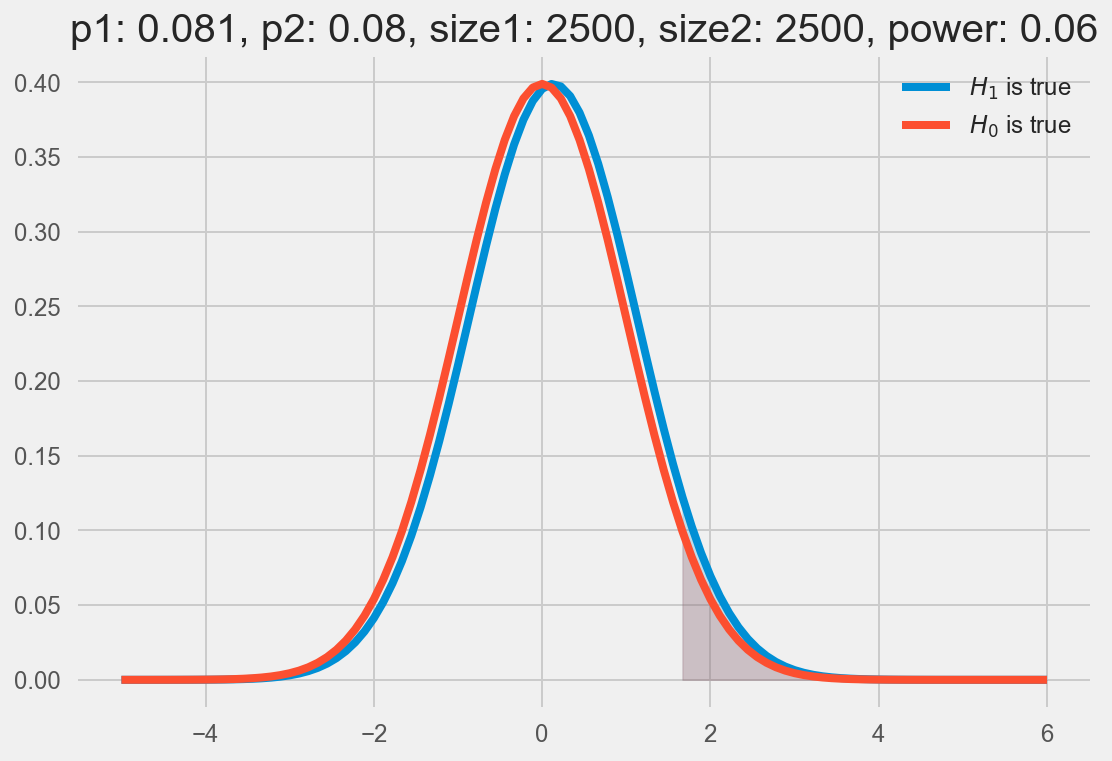

In [42]:
# smaller probability difference
prob_b = 0.08
min_diff = 0.001
size_a = 2500
size_b = 2500

plot_power(min_diff, prob_b, size_a, size_b)


## Determining Sample Size

Say we've followed the rule of thumb and require the significance level to be 5% and the power to be 80%. This means we have now specified two key components of a power analysis.

- A decision rule of when to reject the null hypothesis. We reject the null when the p-value is less than 5%.
- Our tolerance for committing type 2 error (1−80%=20%).

To actually solve for the equation of finding the suitable sample size, we also need to specify the detectable difference, the level of impact we want to be able to detect with our test.
 
In order to explain the dynamics behind this, we'll return to the definition of power: the power is the probability of rejecting the null hypothesis when it is false. Hence for us to calculate the power, we need to define what "false" means to us in the context of the study. In other words, how much impact, i.e., difference between test and control, do we need to observe in order to reject the null hypothesis and conclude that the action worked?

Let's consider two illustrative examples: if we think that an event rate reduction of, say, $10^{-10}$ is enough to reject the null hypothesis, then we need a very large sample size to get a power of 80%. This is pretty easy to deduce from the charts above: if the difference in event rates between test and control is a small number like $10^{-10}$, the null and alternative probability distributions will be nearly indistinguishable. Hence we will need to increase the sample size in order to move the alternative distribution to the right and gain power. Conversely, if we only require a reduction of 0.02 in order to claim success, we can make do with a much smaller sample size. 

> The smaller the detectable difference, the larger the required sample size

Here's how we could conduct a power test in python:

In [43]:
import statsmodels.stats.api as sms


def compute_sample_size(prop1, min_diff, significance = 0.05, power = 0.8):
    """
    Computes the sample sized required for a two-proportion A/B test;
    result matches R's pwr.2p.test from the pwr package
    
    Parameters
    ----------
    prop1 : float
        The baseline proportion, e.g. conversion rate 
        
    min_diff : float
        Minimum detectable difference
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
    
    power : float, default 0.8
        Often denoted as beta. Power of 0.80 means that there is an 80%
        chance that if there was an effect, we would detect it
        (or a 20% chance that we'd miss the effect)
        
    Returns
    -------
    sample_size : int
        Required sample size for each group of the experiment

    References
    ----------
    R pwr package's vignette
    - https://cran.r-project.org/web/packages/pwr/vignettes/pwr-vignette.html

    Stackoverflow: Is there a python (scipy) function to determine parameters
    needed to obtain a target power?
    - https://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta
    """
    prop2 = prop1 + min_diff
    effect_size = sms.proportion_effectsize(prop1, prop2)
    sample_size = sms.NormalIndPower().solve_power(
        effect_size, power = power, alpha = significance, ratio = 1)
    
    return sample_size

In [44]:
sample_size = compute_sample_size(prop1 = 0.1, min_diff = 0.02)
print('sample size required per group:', sample_size)

('sample size required per group:', 3834.595739884031)


Note that the printed result is the sample size needed for each group!

Unlike the significance level and the power, there are no plug-and-play values we can use for the detectable difference. The key is to define what "pay off" means for the study at hand, which depends on what the adverse event is a well as the cost of the action. Two guiding principles:

- **Avoid wasteful sampling** Let’s say it takes an absolute difference of 0.02 between test and control in order for the treatment to pay off. In this case, aiming for a 0.01 detectable difference would just lead to more precision than we really need. Why have the ability to detect 0.01 if we don’t really care about a 0.01 difference? In many cases, sampling for unnecessary precision can be costly and a waste of time
- **Avoid missed opportunities** Conversely, if we are analyzing a sensitive metric where small changes can have a large impact e.g. email campaigns, we have to aim for a small detectable difference. If we choose an insufficient sample size, we may end up sitting on our hands and missing an opportunity (type 2 error)

Hence, choosing the minimum detectable difference should be a cross-functional analysis/discussion between the data scientist and the business stakeholder. Once there is a viable range for the detectable difference, we can evaluate the sample size required for each option. For example, let’s say that $p1=0.10$ and we want the detectable difference to be between 0.01 and 0.03. Clearly, we’d rather be able to detect a difference of 0.01, but it may be too costly and hence we want to evaluate more conservative options as well.

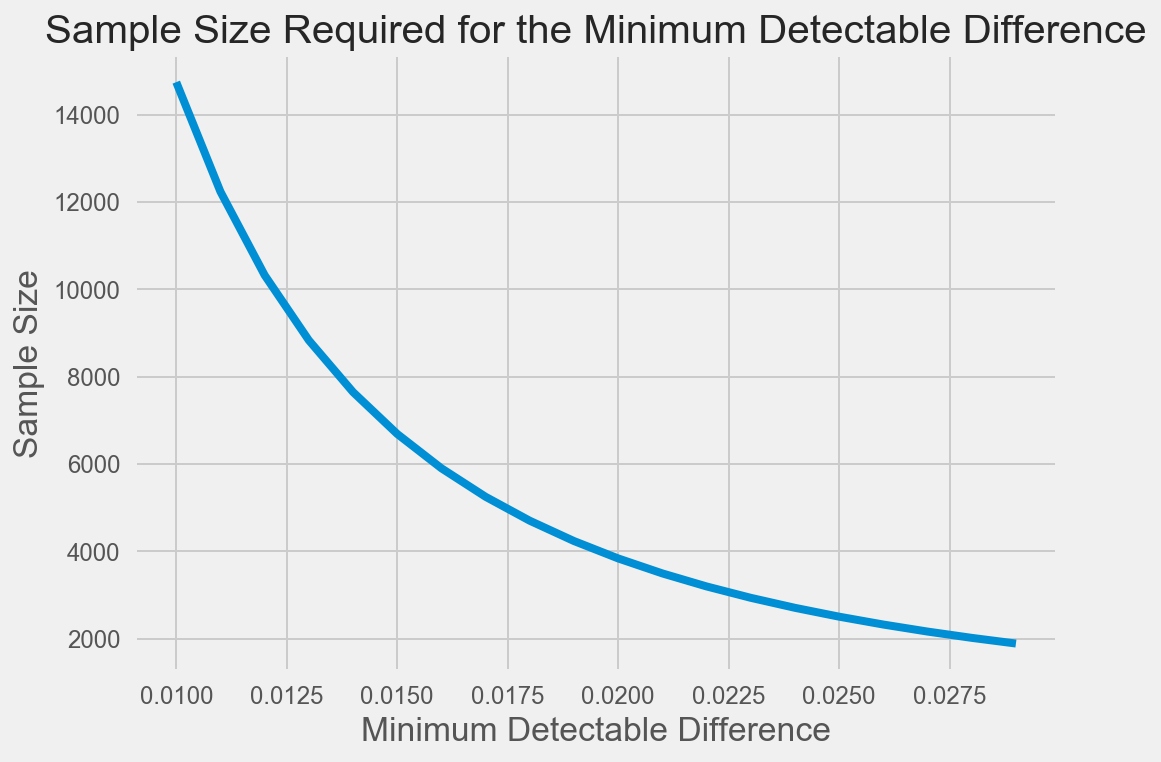

In [45]:
# calculate the the required sample size
# for a range of minimum detectable difference
sample_sizes = []
min_diffs = np.arange(0.01, 0.03, 0.001)
for min_diff in min_diffs:
    sample_size = compute_sample_size(prop1 = 0.1, min_diff = min_diff)
    sample_sizes.append(sample_size)

plt.plot(min_diffs, sample_sizes)
plt.title('Sample Size Required for the Minimum Detectable Difference')
plt.ylabel('Sample Size')
plt.xlabel('Minimum Detectable Difference')
plt.tight_layout()
plt.show()



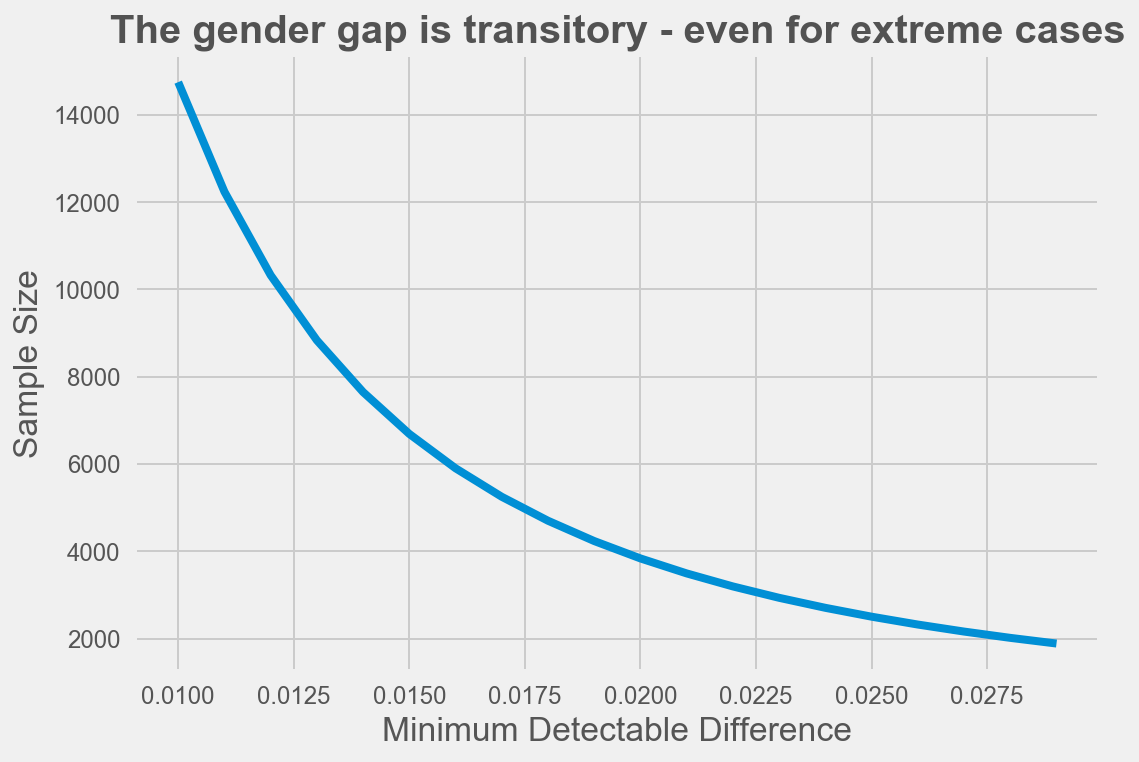

In [62]:
fig = plt.plot(min_diffs, sample_sizes)
ifg = figsize = (20,8)
fig = plt.title(s = "The gender gap is transitory - even for extreme cases",
               fontsize = 20, weight = 'bold', alpha = .78)

fig = plt.ylabel('Sample Size')
fig = plt.xlabel('Minimum Detectable Difference')
fig = plt.tight_layout()
fig 


From the graph, we can see that we need roughly 10x more observations to get a detectable difference of 0.01 compared to 0.03.

The following section is an alternative way of conducting a test statistic for proportional A/B test, feel free to skip it, it will not affect that understanding of later section.

## Alternative View of the Test Statistic

There are two types of the chi-squared test, goodness of fit and test of independence, but it is the latter which is useful for the case in question. The reason as to why a test of “independence” is applicable becomes clear by converting the contingency table into a probability matrix by dividing each element by the grand total of frequencies:

In [46]:
cols = ['not_converted', 'converted']
data[cols] = data[cols] / data[cols].values.sum()
data

,version,not_converted,converted
0,A,0.4514,0.0486
1,B,0.4473,0.0527


We will denote $V$ as the version of the web page ($a$ or $b$) and $C$ as the conversion result, $f$ (false did not convert) or $t$ (true did in fact convert). The table that we computed above, which this the data that we observed can then be translated into this form:


| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a, C = f)$            | $P(V = a, C = t)$              |
|    B        | $P(V = b, C = f)$            | $P(V = b, C = t)$              |


Now, our interest is whether the conversion $C$ depends on the page version $V$, and if it does, to learn which version converts better. In probability theory, the events $C$ and $V$ are said to be independent if the joint probability can be computed by $P(V, C) = P(V) \cdot P(C)$, where $P(V)$ and $P(C)$ are marginal probabilities of $V$ and $C$, respectively. It is straightforward to compute the marginal probabilities from row and column marginals:

$$P(V = a) = \frac{4514 + 486}{10000}  \hspace{1cm} P(V = b) = \frac{4473 + 527}{10000}$$
$$P(C = f) = \frac{4514 + 4473}{10000} \hspace{1cm} P(V = b) = \frac{486 + 527}{10000}$$

The null hypothesis is that $V$ and $C$ are independent, in which case the elements of the matrix, a.k.a the distribution that we're expecting is equivalent to:

| Version (V) | $f$ (false did not convert)  | $t$ (true did in fact convert) |
|:-----------:|:----------------------------:|:------------------------------:|
|    A        | $P(V = a)P(C = f)$           | $P(V = a)P(C = t)$             |
|    B        | $P(V = b)P(C = f)$           | $P(V = b)P(C = t)$             |


The conversion $C$ is said to be dependent on the version $V$ of the web site if this null hypothesis is rejected. Hence rejecting the null hypothesis means that one version is better at converting than the other. This is the reason why the test is on independence.

When dealing with counts and investigating how far the observed counts are from the expected counts, we use a test statistic called the **chi-square test**. The chi-squared test compares an observed distribution $O_{ij}$ to an expected distribution $E_{ij}$:

\begin{align}
\chi^2 = \sum_{i,j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
\end{align}

It's calculated as the observed minus the expected for each cell squared divided by the expected counts, the division with the expected counts makes final result proportional to our expected frequency. After performing the computation for each cell, we want to sum this over all of the cells (levels of the categorical variable).

This $\chi^2$ probability distribution has only one parameter, the degrees of freedom. It influences the shape, the center and the spread of the chi-square distribution.

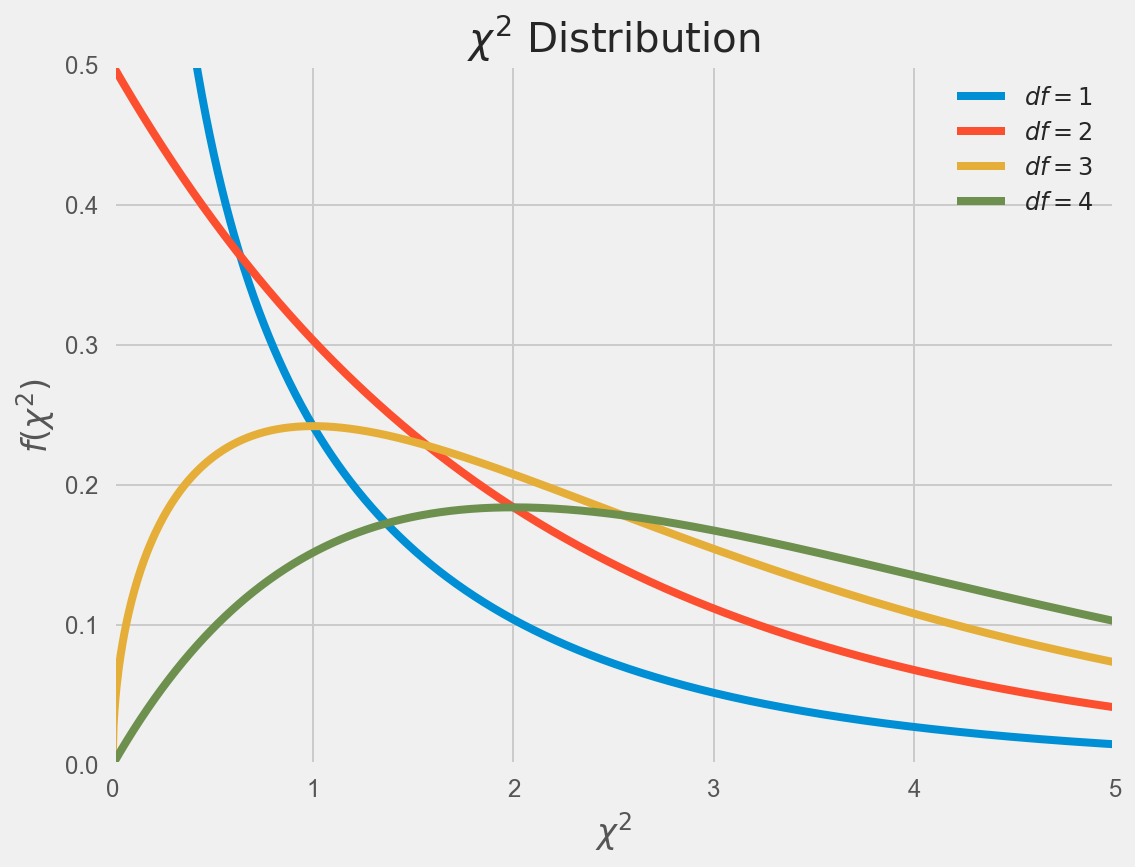

In [47]:
# chi square distribution with varying degrees of freedom
fig = plt.figure(figsize = (8, 6))
x = np.linspace(0, 5, 1000)
deg_of_freedom = [1, 2, 3, 4]
for df in deg_of_freedom:
    plt.plot(x, stats.chi2.pdf(x, df), label = '$df={}$'.format(df))

plt.xlim(0, 5)
plt.ylim(0, 0.5)
plt.xlabel('$\chi^2$')
plt.ylabel('$f(\chi^2)$')
plt.title('$\chi^2\ \mathrm{Distribution}$')
plt.legend()
plt.show()

chi-square distribution gives a way of measuring the difference between the frequencies we observe and the frequencies we expect. The smaller the value of $\chi^2$, the smaller the difference overall between the observed and expected frequencies. The way to compute the degree of freedom for the test of independence using a $r \times c$ contingency matrix is:

\begin{align}
df = (r - 1)(c - 1)
\end{align}

Where $r$ denotes the number of rows and $c$ denotes the number of columns. The rationale behind this calculation is because degrees of freedom is the number of expected frequencies we have to calculate independently after taking into account any restrictions. The restrictions come from the row and column sum constraints, but decreased by one because the last entry in the table/matrix is determined by either the row or column sum on that row/column.

Fortunately it is very straightforward to carry out this hypothesis testing using packages. All we need is to supply the function with a contingency matrix and it will return the $\chi^2$ statistic and the corresponding p-value:

In [23]:
# we can use the proportions_chisquare function,
# where we pass in the number of successes and
# the total number of trials/observation
count = np.array([486, 527])
nobs = np.array([5000, 5000])

# note that in this case (a two sample case with two sided
# alternative), the test produces the same value as porportions_ztest
# since the chi-square distribution is the square of a normal distribution
chisq, pvalue, table = proportions_chisquare(count, nobs)
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754014, pvalue = 0.174193883117


In [24]:
# or the chi2_contingency function where we pass
# in the observed contingency table
observed = np.array([[4514,  486], [4473,  527]])

# more about the correction = False parameter later
result = stats.chi2_contingency(observed, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.8464754014, pvalue = 0.174193883117


The result for our experiment has a  $\chi^2 = 1.74$ and $p = 0.185$. Since the p-value is greater than the standard threshold 0.05, we cannot reject the null hypothesis that the page version and the conversion is independent. Therefore the difference in the conversion rates is not statistically significant.

For a 2 x 2 contingency table, Yate’s chi-squared test is commonly used. This applies a correction of the form:

\begin{align}
\chi^2_{Yate's} = \sum_{i,j} \frac{(\big|O_{ij} - E_{ij}\big| - 0.5)^2}{E_{ij}}
\end{align}

to account for an error between the observed discrete distribution and the continuous chi-squared distribution (the step of -0.5 is often referred to as continuity correction).

In [25]:
# we can use the correcction form, by specifying
# correction = True
result = stats.chi2_contingency(observed, correction = True)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 1.75750186927, pvalue = 0.184936415521


Again, our pvalue is greater than the critical value, hence we simply would not reject the null hypothesis (that there is no relationship between the categorical variables).

> Side note: in practice, we want to make sure that each particular scenario or cell has at least five expected counts before employing the chi-square test.